# Imports

In [348]:
from importlib import reload
from math import log, exp, sqrt, isnan

import numpy as np

import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import hyperopt
from hyperopt import fmin, hp, tpe, Trials

In [2]:
def parent_folder_to_sys_path():
    import os, sys
    dir2 = os.path.abspath('')
    dir1 = os.path.dirname(dir2)
    if not dir1 in sys.path: sys.path.append(dir1)
        
parent_folder_to_sys_path()

In [3]:
from ml_utils import utils

In [4]:
utils = reload(utils)

# Visualization settings

In [5]:
pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (15,5)

# Data Loading

In [534]:
raw_train = pd.read_csv(
    "../input/house-prices-advanced-regression-techniques/train.csv")
raw_test = pd.read_csv(
    "../input/house-prices-advanced-regression-techniques/test.csv")

## Combining train and test datasets into one for further processing

In [543]:
raw_train_copy = raw_train.copy()
raw_train_copy['train'] = True

raw_test_copy = raw_test.copy()
raw_test_copy['train'] = False

combined_data = pd.concat([raw_train_copy, raw_test_copy], axis=0)

## Data Inspection

In [536]:
combined_data['Id'].unique()

array([   1,    2,    3, ..., 2917, 2918, 2919], dtype=int64)

## Checking that all ids in combined dataset are unique

In [524]:
len(combined_data['Id']) == len(combined_data['Id'].unique())

True

## Show how filled are the columns

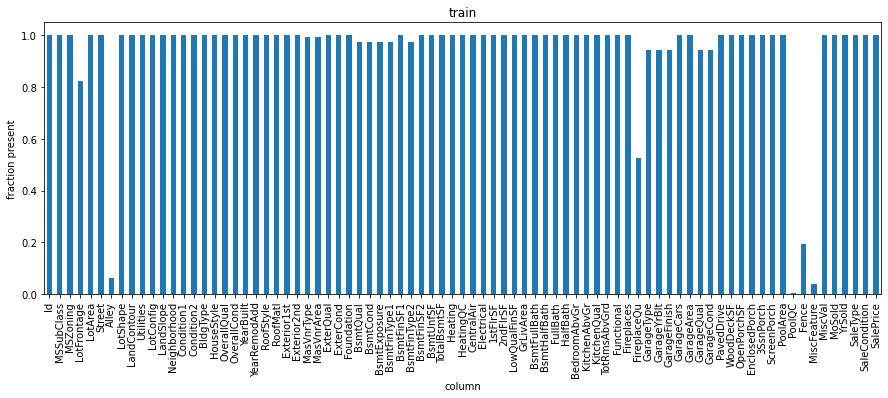

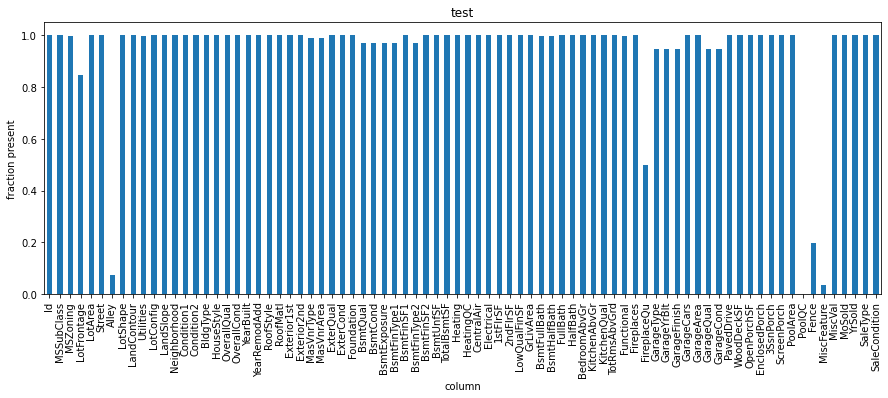

In [456]:
perc_train = utils.get_not_nans_fraction_by_column(raw_train)
perc_train.plot.bar()
plt.title('train')
plt.xlabel('column')
plt.ylabel('fraction present')
plt.show()

perc_test = utils.get_not_nans_fraction_by_column(raw_test)
perc_test.plot.bar()
plt.title('test')
plt.xlabel('column')
plt.ylabel('fraction present')
plt.show()

# Data preparation

In [553]:
combined_data = pd.concat([raw_train_copy, raw_test_copy], axis=0)

In [554]:
# train = raw_train.copy()
# test = raw_test.copy()
# train = train.set_index('Id')
# target = train['SalePrice']
# train = train.drop(columns='SalePrice')

In [555]:
# train = train.drop(coluns = 'Id')

## Converting basement and garage variables to int relying on data desctiption

In [556]:
combined_data['BsmtQual'].value_counts()

TA    1283
Gd    1209
Ex     258
Fa      88
Name: BsmtQual, dtype: int64

In [544]:
# combined_data['BsmtQual'] = combined_data['BsmtQual'].replace({
#     'Ex': 5,
#     'Gd': 4,
#     'TA': 3,
#     'Fa': 2,
#     'Po': 1, 
# }).fillna(0)

combined_data['BsmtCond'] = combined_data['BsmtCond'].replace({
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1, 
}).fillna(0)

combined_data['BsmtExposure'] = combined_data['BsmtExposure'].replace({
    'Gd': 4,
    'Av': 3,
    'Mn': 2,
    'No': 1, 
}).fillna(0)

combined_data['BsmtFinType1'] = combined_data['BsmtFinType1'].replace({
    'GLQ': 6,
    'ALQ': 5,
    'BLQ': 4,
    'Rec': 3,
    'LwQ': 2, 
    'Unf': 1,
}).fillna(0)

combined_data['BsmtFinType2'] = combined_data['BsmtFinType2'].replace({
    'GLQ': 6,
    'ALQ': 5,
    'BLQ': 4,
    'Rec': 3,
    'LwQ': 2, 
    'Unf': 1,
}).fillna(0)

In [557]:
combined_data[[column for column in combined_data.columns if 'Bsmt' in column]].dtypes

BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinSF1      float64
BsmtFinType2     object
BsmtFinSF2      float64
BsmtUnfSF       float64
TotalBsmtSF     float64
BsmtFullBath    float64
BsmtHalfBath    float64
dtype: object

## Numerical and categorical split

In [558]:
numerical, categorical = utils.num_cat_split(combined_data.drop(columns='train'))

Numerical dtypes are ['int64', 'float64']
Numerical columns are ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Id', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal', 'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea', 'SalePrice', 'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']


Categorical dtypes are ['object']
Categorical columns are ['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'K

## One-hot encoding all categorical data

In [559]:
categorical_with_dummies = pd.get_dummies(categorical)

## Merging all data and splitting it into train and test sets

In [560]:
combined_data = pd.concat([
    categorical_with_dummies, numerical, combined_data[['train']]], axis=1)

In [561]:
full_train = combined_data[combined_data['train'] == True].drop(columns=['Id', 'train'])
target = full_train['SalePrice']
full_train = full_train.drop(columns='SalePrice')

test = combined_data[combined_data['train'] == False].drop(columns=['Id', 'train', 'SalePrice'])

x_train, x_val, y_train, y_val = [df.reset_index(drop=True) for df in \
    train_test_split(full_train, target, test_size=0.20, random_state=100)] #remove reset index

# Model selection using hyperopt

In [341]:
NONOPTIMIZED_XGB_SETTINGS = dict(
    booster='gbtree',
    importance_type='gain',
    n_estimators=2400,
    objective='reg:squarederror',
    n_jobs=-1)

## Initializing trials object and dataframe with statistics

In [342]:
trials = Trials()
hyperopt_stats = pd.DataFrame()

## Defining search space and objective function

In [345]:
space = {
     'learning_rate': hp.choice('learning_rate', [0.02]),
     'max_depth': hp.choice('max_depth', [4, 5, 6]),
     'min_child_weight': hp.uniform('min_child_weight', 0.8, 4),
     'subsample': hp.uniform('subsample', 0.01, 1),
     'colsample_bytree': hp.uniform('colsample_bytree', 0.01, 1),
     'min_split_loss': hp.uniform('min_split_loss', 0, 0.15),
}


def objective(args):
    xgb =XGBRegressor(
        **NONOPTIMIZED_XGB_SETTINGS,
        **args,
    )

    res = cross_validate(xgb, x_train.values, y_train.values,
                         n_jobs=-1, cv=4, scoring='neg_root_mean_squared_error',
                         return_train_score=True)
    means = {key: -value.mean() for key, value in res.items() if key in ['train_score', 'test_score']}
    
    row = {**args, **means}#, 'independent_test_score': independent_test_score}
    global hyperopt_stats
    hyperopt_stats = hyperopt_stats.append(row, ignore_index = True)
    return means['test_score']

## Launching hyperopt (takes several hours)

In [353]:
# minimize the objective over the space
hyperopt_stats = pd.DataFrame()
best = fmin(objective, space, trials = trials, algo=tpe.suggest, max_evals=)
best_params = hyperopt.space_eval(space, best)

 99%|███████████████████████████████████████████▋| 298/300 [1:53:03<00:50, 25.03s/trial, best loss: 25257.671754086296]


{'colsample_bytree': 0.9798157938447801,
 'learning_rate': 0.02,
 'max_depth': 4,
 'min_child_weight': 1.894136193318465,
 'min_split_loss': 0.14671663992428727,
 'subsample': 0.4350029695690586}

## Shortcut for skipping hyperopt

In [401]:
best_params = {
     'colsample_bytree': 0.9798157938447801,
     'learning_rate': 0.02,
     'max_depth': 4,
     'min_child_weight': 1.894136193318465,
     'min_split_loss': 0.14671663992428727,
     'subsample': 0.4350029695690586}

## Viewing stats

In [355]:
hyperopt_stats.sort_values(by = 'test_score', ascending=False)

,colsample_bytree,independent_test_score,learning_rate,max_depth,min_child_weight,min_split_loss,subsample,test_score,train_score
6,0.012552,33078.860558,0.02,4.0,3.490957,0.134794,0.036234,34821.560015,33459.526864
185,0.865316,27134.165015,0.02,5.0,3.006245,0.015751,0.034845,30471.192332,25111.146040
296,0.015473,29221.724123,0.02,6.0,1.904472,0.146350,0.270985,30082.780280,14629.353589
184,0.835773,27076.758512,0.02,4.0,0.800856,0.089359,0.154749,29971.969594,5316.895406
101,0.774755,27575.952060,0.02,4.0,1.888146,0.072711,0.019790,29959.137207,25077.604658
...,...,...,...,...,...,...,...,...,...
268,0.814287,27190.723028,0.02,6.0,1.693938,0.147463,0.282184,25635.456537,1722.054522
292,0.914633,27214.017480,0.02,6.0,1.942805,0.134964,0.330575,25569.422328,1087.913923
270,0.813544,27532.604563,0.02,6.0,1.732669,0.137555,0.287874,25553.427406,1554.907557
229,0.999069,26189.035141,0.02,4.0,1.737692,0.146203,0.435201,25478.404388,1803.375816


## Plotting feature vs loss graphs

c:\users\peter\.virtualenvs\house-prices-advanced-regression-technique-j10vgbhm\lib\site-packages\IPython\core\interactiveshell.py:3417: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


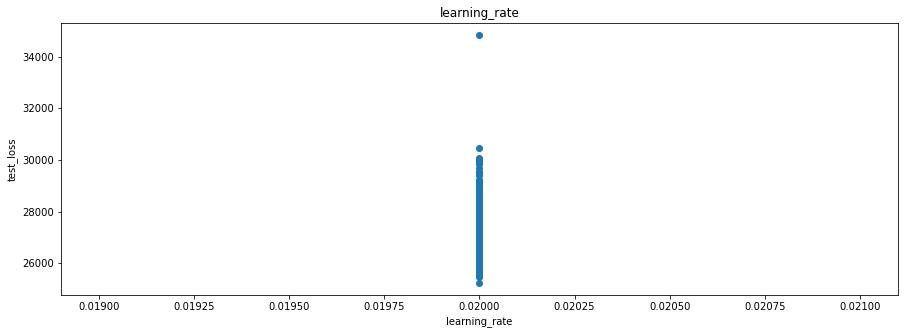

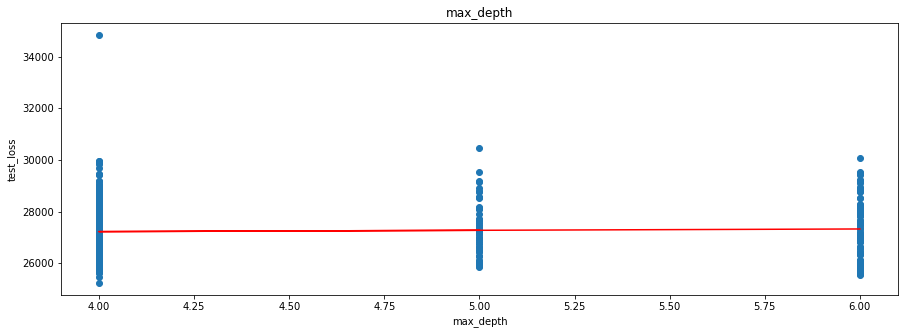

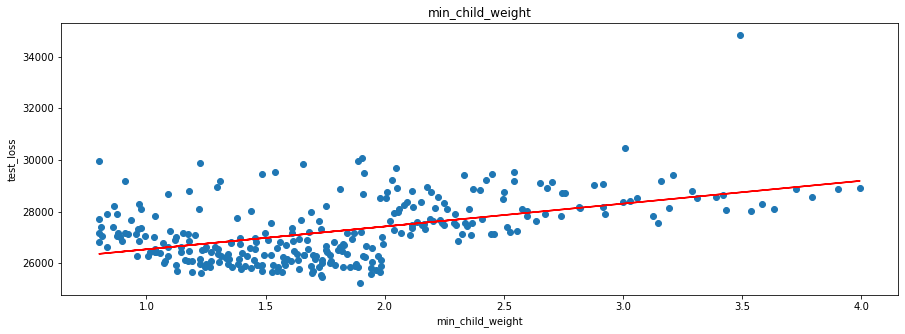

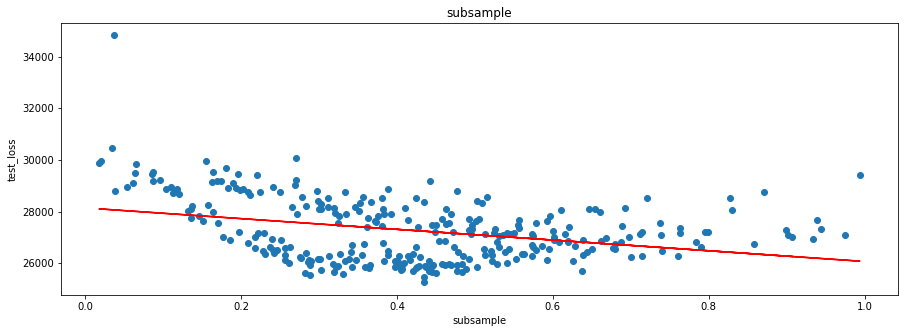

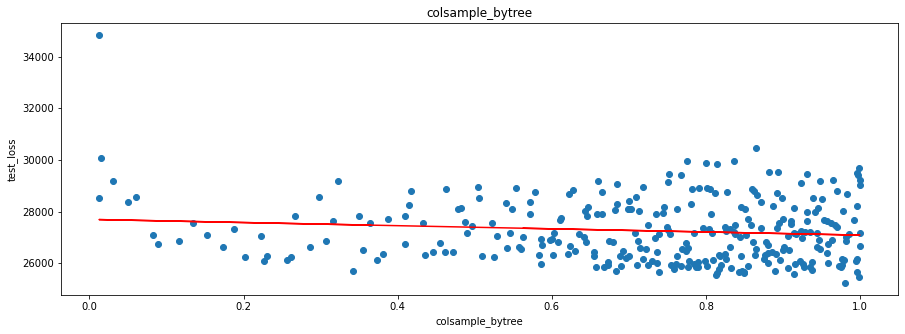

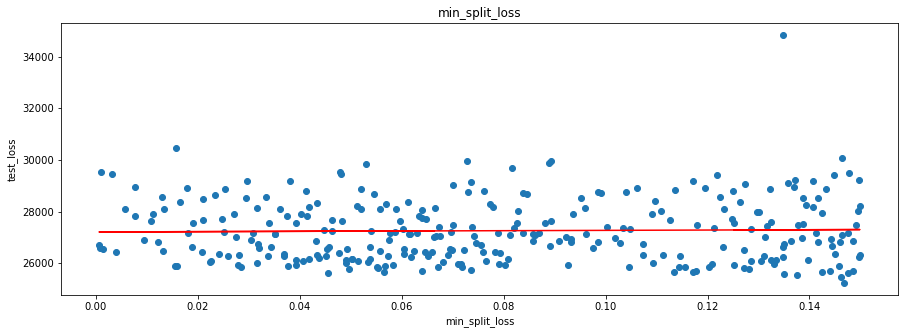

In [362]:
for column in space.keys():
    x = hyperopt_stats[column]
    y = hyperopt_stats['test_score']
    plt.scatter(x, y)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),"r")
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('validation_loss')
    axes = plt.gca()
#     axes.set_ylim([25000,40000])
    plt.show()

# Calculating independent validation score

In [488]:
xgb =XGBRegressor(
    **NONOPTIMIZED_XGB_SETTINGS,
    **best_params)

In [499]:
xgb.fit(x_train, y_train) #old
prediction = xgb.predict(x_val)
metric = mean_squared_error(y_val, prediction, squared=False)
metric

22622.588927312227

In [550]:
#new_basement2
res = cross_validate(xgb, full_train, target,
                     n_jobs=-1, cv=4, scoring='neg_root_mean_squared_error',
                     return_train_score=True)
print(f'cv scores:\n {np.sort(-res["test_score"])}')
print(f'cv mean:\n {-res["test_score"].mean()}\n')

cv scores:
 [21598.15396366 23323.76617669 27028.58298145 32895.35952202]
cv mean:
 26211.465660956488



In [533]:
#new_basement1
res = cross_validate(xgb, full_train, target,
                     n_jobs=-1, cv=4, scoring='neg_root_mean_squared_error',
                     return_train_score=True)
print(f'cv scores:\n {np.sort(-res["test_score"])}')
print(f'cv mean:\n {-res["test_score"].mean()}\n')

cv scores:
 [21409.71519955 23586.776335   27104.10940085 32874.9460786 ]
cv mean:
 26243.886753496863



In [562]:
#old
res = cross_validate(xgb, full_train, target,
                     n_jobs=-1, cv=4, scoring='neg_root_mean_squared_error',
                     return_train_score=True)
print(f'cv scores:\n {np.sort(-res["test_score"])}')
print(f'cv mean:\n {-res["test_score"].mean()}\n')

cv scores:
 [21422.25803668 23558.98712784 27188.21887295 32041.06586813]
cv mean:
 26052.632476397703



# Additional exploration

## Comparing cv score during training with independent test score (may take several hours)

In [ ]:
hyperopt_stats['independent_validation_score'] = np.nan

In [354]:
for i, row in hyperopt_stats.iterrows():
    if isnan(row['independent_validation_score']):
        row_dict = row.to_dict()
        params = {param_name: param for param_name, param in row_dict.items() if param_name in space}
        params['max_depth'] = int(params['max_depth'])
        print(params)
        xgb =XGBRegressor(
        **NONOPTIMIZED_XGB_SETTINGS,
        **params)
        xgb.fit(x_train, y_train)
        prediction = xgb.predict(x_val)
        metric = mean_squared_error(y_val, prediction, squared=False)
        row['independent_validation_score'] = metric
        

{'colsample_bytree': 0.48780569524017764, 'learning_rate': 0.02, 'max_depth': 6, 'min_child_weight': 2.1334256266933016, 'min_split_loss': 0.13248746693987185, 'subsample': 0.5015453496241429}
{'colsample_bytree': 0.012551722149216672, 'learning_rate': 0.02, 'max_depth': 4, 'min_child_weight': 3.4909573547411563, 'min_split_loss': 0.13479442981058826, 'subsample': 0.036234478245637435}
{'colsample_bytree': 0.4959942269972374, 'learning_rate': 0.02, 'max_depth': 4, 'min_child_weight': 2.3461755918849523, 'min_split_loss': 0.13169472736233603, 'subsample': 0.6893658335609317}
{'colsample_bytree': 0.48250474646358243, 'learning_rate': 0.02, 'max_depth': 4, 'min_child_weight': 3.1942517880909884, 'min_split_loss': 0.03156548280649104, 'subsample': 0.3186985588115645}
{'colsample_bytree': 0.6846497159593362, 'learning_rate': 0.02, 'max_depth': 4, 'min_child_weight': 2.91588291836485, 'min_split_loss': 0.127389347556449, 'subsample': 0.06126807874920075}
{'colsample_bytree': 0.18807729937592

train_score_cv             1857.285053
test_score_cv             25257.671754
independent_test_score    26190.841670
Name: 0, dtype: float64

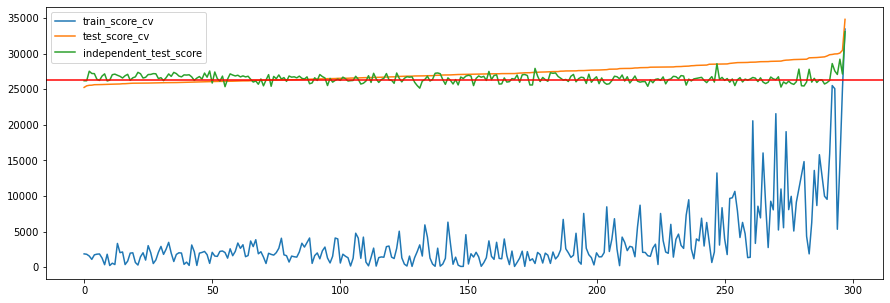

In [388]:
ranked_stats = hyperopt_stats.sort_values(by= 'test_score').reset_index(drop = True)
scores = ranked_stats[['train_score', 'test_score', 'independent_validation_score']]
scores = scores.rename(columns={'train_score': 'train_score_cv', 'test_score': 'test_score_cv'})
scores.plot()
plt.axhline(y=26350, color='r', linestyle='-')
scores.iloc[0]

## Viewing how increase in tree count impacts train and test scores

In [389]:
train_metrics = []
val_metrics = []

for n_est in range(100, 2500, 100):
    settings = {**NONOPTIMIZED_XGB_SETTINGS, **best_params}
    settings['n_estimators'] = n_est
    xgb =XGBRegressor(
            **settings
    )
    xgb.fit(x_train, y_train)
    prediction_val = xgb.predict(x_val)
    prediction_train = xgb.predict(x_train)
    val_metrics.append(mean_squared_error(y_val, prediction_val, squared=False))
    train_metrics.append(mean_squared_error(y_train, prediction_train, squared=False))
    

Text(0.5, 0, 'n_estimators')

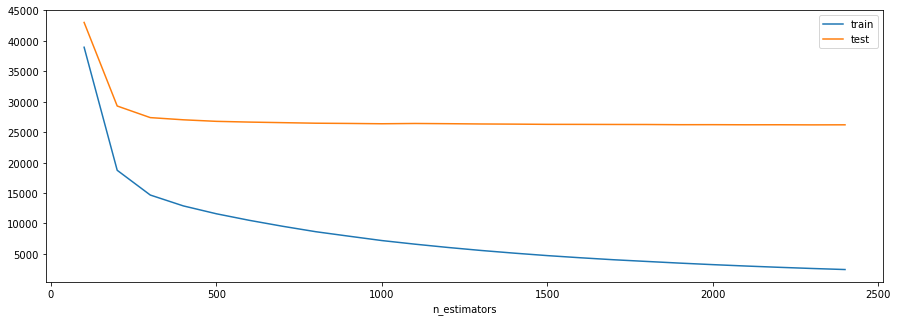

In [391]:
plt.plot(range(100, 2500, 100), train_metrics, label = 'train')
plt.plot(range(100, 2500, 100), val_metrics, label = 'validation')
plt.legend()
plt.xlabel('n_estimators')

## Feature importances

<AxesSubplot:>

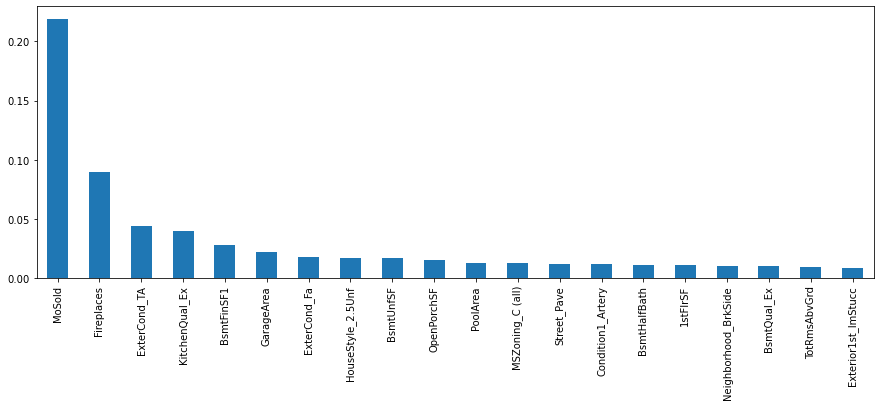

In [563]:
importances = pd.Series(dict(zip(x_train.columns, xgb.feature_importances_)))
importances.sort_values(ascending=False)[:20].plot.bar()

In [567]:
pd.Series({key: value for key, value in importances.items() if 'Bsmt' in key}).sort_values()

BsmtCond_Po         0.000000
BsmtFinType2_GLQ    0.000204
BsmtFinType1_BLQ    0.000376
BsmtFinType2_ALQ    0.000415
BsmtFinType1_LwQ    0.000493
BsmtFinType2_Rec    0.000499
BsmtExposure_Mn     0.000549
BsmtCond_TA         0.000702
BsmtFinType1_Unf    0.000732
BsmtFinType1_Rec    0.000737
BsmtFinType2_LwQ    0.000773
BsmtFinType2_Unf    0.000774
BsmtCond_Gd         0.000862
BsmtFinType2_BLQ    0.000864
BsmtExposure_Av     0.000955
BsmtFinType1_ALQ    0.001097
BsmtFullBath        0.001218
BsmtExposure_No     0.001394
BsmtFinSF2          0.001842
BsmtQual_Gd         0.002243
BsmtQual_Fa         0.002612
BsmtFinType1_GLQ    0.002874
BsmtCond_Fa         0.003446
TotalBsmtSF         0.004265
BsmtExposure_Gd     0.007060
BsmtQual_TA         0.007810
BsmtQual_Ex         0.010175
BsmtHalfBath        0.011417
BsmtUnfSF           0.016635
BsmtFinSF1          0.028057
dtype: float64